## Data Mining - Numeric Prediction (*Price of a new car*)

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV, learning_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

import arabic_reshaper
from bidi.algorithm import get_display

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
RANDOM_STATE = 42

---

### Load and inspect dataset

In [3]:
df = pd.read_csv("data.csv")

In [4]:
df.head()

,خودرو,تیپ,نوع رنگ,مدل,کارکرد,بیمه,گیربکس,موتور,شاسی,بدنه,عکس,قیمت,شهر
0,206.0,2.0,سفید,1397.0,110000,10,دنده ای,سالم,سالم و پلمپ,سالم و بی خط و خش,دارد,490000000,شیراز
1,206.0,2.0,نقره ای,1383.0,300000,6,دنده ای,سالم,سالم و پلمپ,سالم و بی خط و خش,دارد,242000000,شیراز
2,206.0,2.0,طلایی,1383.0,500000,3,دنده ای,سالم,سالم و پلمپ,سالم و بی خط و خش,دارد,240000000,شیراز
3,206.0,2.0,مشکی,1384.0,300000,5,دنده ای,سالم,سالم و پلمپ,سالم و بی خط و خش,دارد,238000000,شیراز
4,206.0,2.0,قرمز,1400.0,35000,4,دنده ای,سالم,سالم و پلمپ,سالم و بی خط و خش,دارد,590000000,شیراز


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   خودرو    389 non-null    float64
 1   تیپ      389 non-null    float64
 2   نوع رنگ  389 non-null    object 
 3   مدل      389 non-null    float64
 4   کارکرد   390 non-null    object 
 5   بیمه     389 non-null    object 
 6   گیربکس   389 non-null    object 
 7   موتور    381 non-null    object 
 8   شاسی     377 non-null    object 
 9   بدنه     386 non-null    object 
 10  عکس      389 non-null    object 
 11  قیمت     386 non-null    object 
 12  شهر      389 non-null    object 
dtypes: float64(3), object(10)
memory usage: 39.7+ KB


In [6]:
df.shape

(390, 13)

---

### Preprocessing

In [7]:
print("\nMissing values:\n", df.isnull().sum())


Missing values:
 خودرو       1
تیپ         1
نوع رنگ     1
مدل         1
کارکرد      0
بیمه        1
گیربکس      1
موتور       9
شاسی       13
بدنه        4
عکس         1
قیمت        4
شهر         1
dtype: int64


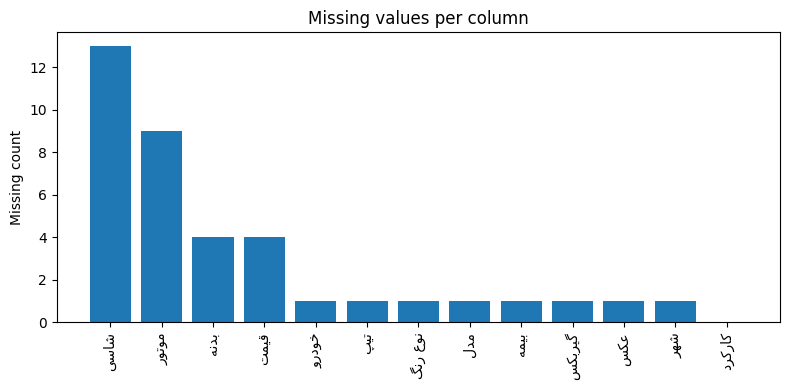

In [8]:
na_counts = df.isnull().sum().sort_values(ascending=False)
labels = [get_display(arabic_reshaper.reshape(str(lbl))) for lbl in na_counts.index.astype(str)]

plt.figure(figsize=(8, 4))
plt.bar(labels, na_counts.values)
plt.xticks(rotation=90)
plt.ylabel("Missing count")
plt.title("Missing values per column")
plt.tight_layout()
plt.show()

#### Handling Missing Values

In [9]:
TARGET = "قیمت"

In [10]:
def persian_to_english(s):
    """Convert Persian/Arabic digits to English digits."""
    if pd.isna(s):
        return np.nan
    s = str(s)
    persian_digits = "۰۱۲۳۴۵۶۷۸۹"
    arabic_digits = "٠١٢٣٤٥٦٧٨٩"
    for p, e in zip(persian_digits, "0123456789"):
        s = s.replace(p, e)
    for a, e in zip(arabic_digits, "0123456789"):
        s = s.replace(a, e)
    return s

In [11]:
# Apply digit normalization
df[TARGET] = df[TARGET].apply(persian_to_english)

# Remove commas, spaces, non-digits
df[TARGET] = df[TARGET].str.replace(r"[^\d.]", "", regex=True)

# Convert to float
df[TARGET] = pd.to_numeric(df[TARGET], errors="coerce")

# Fill missing with median
df[TARGET] = df[TARGET].fillna(df[TARGET].median())

print(df[TARGET].dtype)
print(df[TARGET].head(10))

float64
0    490000000.0
1    242000000.0
2    240000000.0
3    238000000.0
4    590000000.0
5    282000000.0
6    370000000.0
7    200000000.0
8    405000000.0
9    370000000.0
Name: قیمت, dtype: float64


Identify feature columns automatically

In [12]:
feature_cols = [c for c in df.columns if c != TARGET]
feature_cols

['خودرو',
 'تیپ',
 'نوع رنگ',
 'مدل',
 'کارکرد',
 'بیمه',
 'گیربکس',
 'موتور',
 'شاسی',
 'بدنه',
 'عکس',
 'شهر']

Since car, trim, and gearbox values are the same all over the dataset, we remove these features.

In [13]:
print(df["خودرو"].unique())
print(df["تیپ"].unique())
print(df["گیربکس"].unique())

[206.  nan]
[ 2. nan]
['دنده ای' 'دنده' 'دنده ایی' nan]


In [14]:
df = df.drop(columns=["خودرو", "تیپ", "گیربکس"])

In [15]:
feature_cols = [c for c in df.columns if c != TARGET]
feature_cols

['نوع رنگ', 'مدل', 'کارکرد', 'بیمه', 'موتور', 'شاسی', 'بدنه', 'عکس', 'شهر']

Type cast categorical values to numerical forms

In [16]:
for col in ["بیمه", "کارکرد"]:
    df[col] = (
        df[col].astype(str)
        .str.replace(r"[^\d.]", "", regex=True)
        .replace("", np.nan)
    )
    df[col] = pd.to_numeric(df[col], errors="coerce")

Extract categorical columns

In [17]:
categorical_cols = list(df[feature_cols].select_dtypes(exclude=[np.number]).columns)
print("Categorical columns:", categorical_cols)

Categorical columns: ['نوع رنگ', 'موتور', 'شاسی', 'بدنه', 'عکس', 'شهر']


Categorical value standardization

In [18]:
df["نوع رنگ"].unique()

array(['سفید', 'نقره ای', 'طلایی', 'مشکی', 'قرمز', 'دلفینی', 'ابی',
       'نوک مدادی', 'بژ', 'آبی', 'نقره', 'خاکستری', 'نفره ای', 'نقرآبی',
       'بادمجانی', 'یشمی', 'گیلاسی', 'آلبالویی', 'کرم', 'سسفید صدفی',
       'سفید صدفی', 'البالویی', 'بنفش', 'ذغالی', 'طوسی', nan],
      dtype=object)

In [19]:
df["نوع رنگ"] = df["نوع رنگ"].replace("نفره ای", "نقره ای")
df["نوع رنگ"] = df["نوع رنگ"].replace("ابی", "آبی")
df["نوع رنگ"] = df["نوع رنگ"].replace("البالویی", "آلبالویی")
df["نوع رنگ"] = df["نوع رنگ"].replace("سسفید صدفی", "سفید صدفی")
df["نوع رنگ"].unique()

array(['سفید', 'نقره ای', 'طلایی', 'مشکی', 'قرمز', 'دلفینی', 'آبی',
       'نوک مدادی', 'بژ', 'نقره', 'خاکستری', 'نقرآبی', 'بادمجانی', 'یشمی',
       'گیلاسی', 'آلبالویی', 'کرم', 'سفید صدفی', 'بنفش', 'ذغالی', 'طوسی',
       nan], dtype=object)

In [20]:
df["شاسی"].unique()


array(['سالم و پلمپ', 'ضربه خورده', nan, 'سالم و پلمپ ', 'ضربه ',
       ' سالم و پلمپ', 'ضربه', 'تعیین'], dtype=object)

In [21]:
df["شاسی"] = df["شاسی"].replace("سالم و پلمپ ", "سالم و پلمپ")
df["شاسی"] = df["شاسی"].replace(" سالم و پلمپ", "سالم و پلمپ")
df["شاسی"] = df["شاسی"].replace("ضربه ", "ضربه خورده")
df["شاسی"] = df["شاسی"].replace("ضربه", "ضربه خورده")
df["شاسی"].unique()

array(['سالم و پلمپ', 'ضربه خورده', nan, 'تعیین'], dtype=object)

In [22]:
df["بدنه"].unique()

array(['سالم و بی خط و خش', 'دور رنگ', 'خط و خش جزئی', 'تمام رنگ',
       'رنگ شدگی در 1 ناحیه', 'رنگ شدگی در 5 ناحیه ',
       'رنگ شدگی در 2 ناحیه', 'رنگ شدگی در 3 ناحیه', 'رنگ ', 'تصادفی',
       'تمام ', 'رنگ شدگی در ۱ ناحیه', 'رنگ شدگی در ۲ ناحیه',
       'رنگ شدگی در ۳ ناحیه', 'رنگ شدگی در۲ ناحیه', 'رنگ', nan,
       'سالم و بی خط و خش ', 'رنگ شدگی در 4 ناحیه', 'رنگ شدگی در 5 ناحیه',
       'رنگ شدگی در  ناحیه', 'رنگ شده در ۴ ناحیه'], dtype=object)

In [23]:
df["بدنه"] = df["بدنه"].apply(persian_to_english)
df["بدنه"].unique()

array(['سالم و بی خط و خش', 'دور رنگ', 'خط و خش جزئی', 'تمام رنگ',
       'رنگ شدگی در 1 ناحیه', 'رنگ شدگی در 5 ناحیه ',
       'رنگ شدگی در 2 ناحیه', 'رنگ شدگی در 3 ناحیه', 'رنگ ', 'تصادفی',
       'تمام ', 'رنگ شدگی در2 ناحیه', 'رنگ', nan, 'سالم و بی خط و خش ',
       'رنگ شدگی در 4 ناحیه', 'رنگ شدگی در 5 ناحیه', 'رنگ شدگی در  ناحیه',
       'رنگ شده در 4 ناحیه'], dtype=object)

In [24]:
df["بدنه"] = df["بدنه"].replace("سالم و بی خط و خش ", "سالم و بی خط و خش")
df["بدنه"] = df["بدنه"].replace("تمام ", "تمام رنگ")
df["بدنه"] = df["بدنه"].replace("رنگ شدگی در2 ناحیه", "رنگ شدگی در 2 ناحیه")
df["بدنه"] = df["بدنه"].replace("رنگ شده در 4 ناحیه", "رنگ شدگی در 4 ناحیه")
df["بدنه"] = df["بدنه"].replace("رنگ شدگی در 5 ناحیه ", "رنگ شدگی در 5 ناحیه")
df["بدنه"] = df["بدنه"].replace("رنگ شدگی در  ناحیه", np.nan)
df["بدنه"] = df["بدنه"].replace("رنگ", np.nan)
df["بدنه"] = df["بدنه"].replace("رنگ ", np.nan)
df["بدنه"].unique()

array(['سالم و بی خط و خش', 'دور رنگ', 'خط و خش جزئی', 'تمام رنگ',
       'رنگ شدگی در 1 ناحیه', 'رنگ شدگی در 5 ناحیه',
       'رنگ شدگی در 2 ناحیه', 'رنگ شدگی در 3 ناحیه', nan, 'تصادفی',
       'رنگ شدگی در 4 ناحیه'], dtype=object)

In [25]:
df["عکس"].unique()

array(['دارد', 'ندارد', nan], dtype=object)

In [26]:
df["شهر"].unique()

array(['شیراز', 'گیلان', 'اصفهان', 'تهران', 'کرج', 'بوشهر', 'مشهد',
       'شهرکرد', 'ساری', 'تبریز', 'آبادان', 'همدان', 'سیرجان', 'لاهیجان',
       'ماهدشت', 'بیرجند', 'زاهدان', 'یزد', 'رشت', 'سمنان', 'ارومیه',
       'قم', 'ابادان', 'گرگان', 'جم', nan], dtype=object)

In [27]:
df["شهر"] = df["شهر"].replace("ابادان", "آبادان")
df["شهر"].unique()

array(['شیراز', 'گیلان', 'اصفهان', 'تهران', 'کرج', 'بوشهر', 'مشهد',
       'شهرکرد', 'ساری', 'تبریز', 'آبادان', 'همدان', 'سیرجان', 'لاهیجان',
       'ماهدشت', 'بیرجند', 'زاهدان', 'یزد', 'رشت', 'سمنان', 'ارومیه',
       'قم', 'گرگان', 'جم', nan], dtype=object)

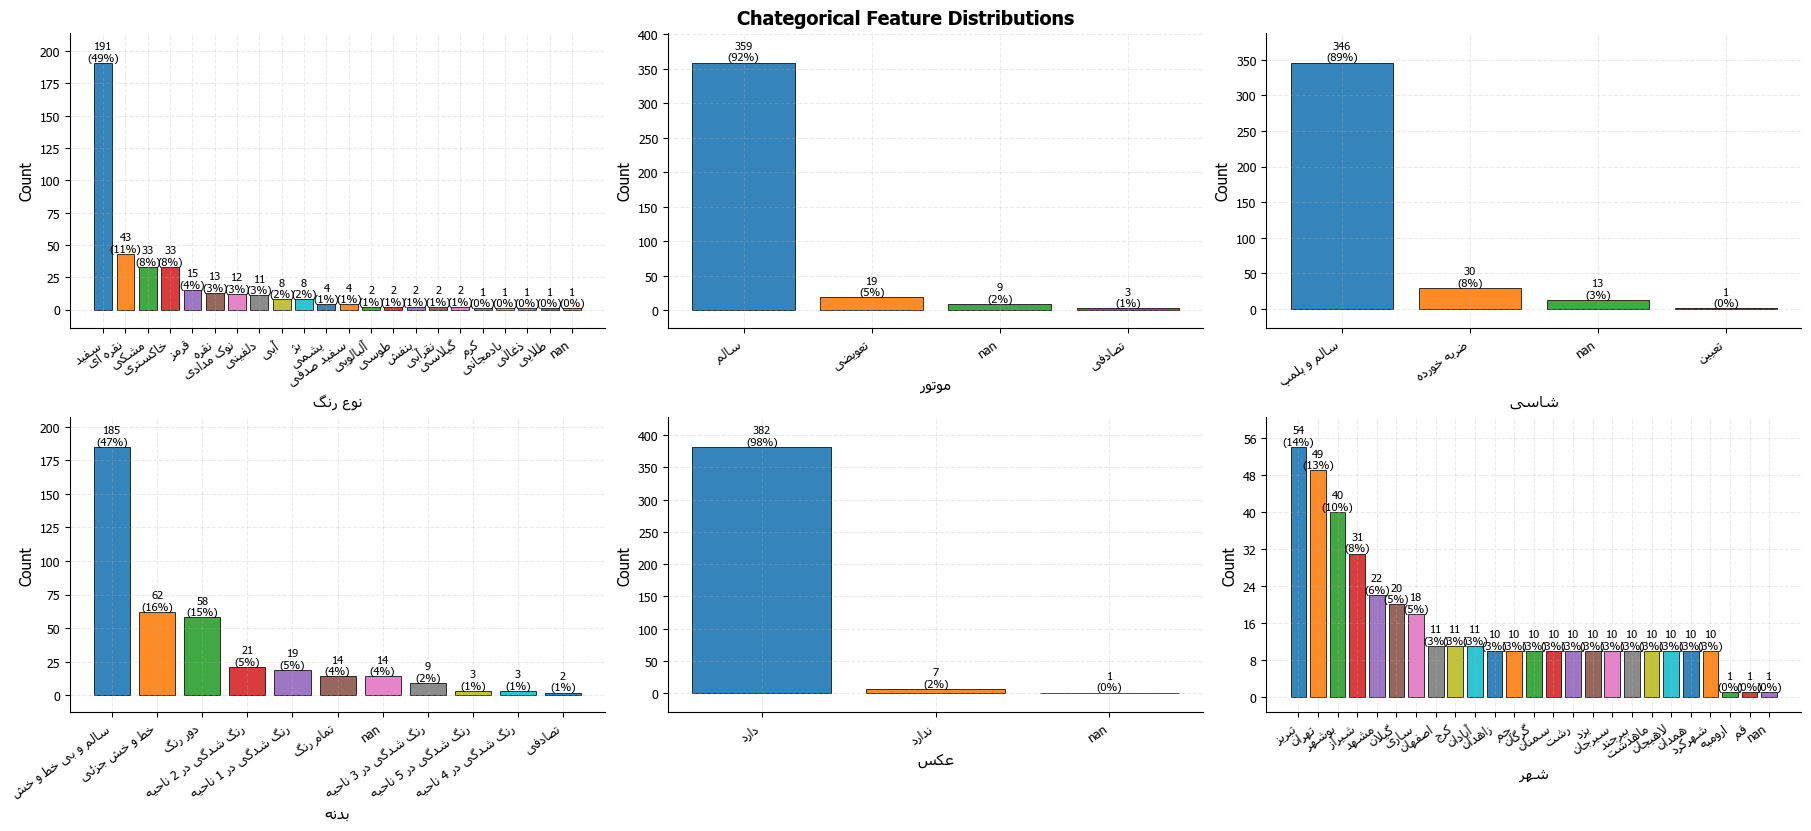

In [28]:
def rtl(s: str) -> str:
    return get_display(arabic_reshaper.reshape(str(s)))

plt.rcParams.update({
    "font.family": "Tahoma",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "--",
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
})

rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(18, 8), constrained_layout=True)
axes = axes.ravel()

for i, c in enumerate(categorical_cols[:rows * cols]):
    vc = df[c].value_counts(dropna=False)
    labels = [rtl(x) for x in vc.index.astype(str)]
    vals   = vc.values
    idx    = np.arange(len(vc))

    ax = axes[i]
    cmap = plt.get_cmap("tab10")
    colors = [cmap(j % cmap.N) for j in range(len(idx))]

    bars = ax.bar(idx, vals, color=colors, edgecolor="black", linewidth=0.6, alpha=0.9)

    ax.set_xticks(idx)
    ax.set_xticklabels(labels, rotation=35, ha="right")
    ax.set_xlabel(rtl(c))
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    vmin, vmax = vals.min(), vals.max()
    span = max(1, vmax - vmin)
    ax.set_ylim(vmin - 0.08 * (span + 1), vmax + 0.12 * (span + 1))
    total = vals.sum() if vals.sum() > 0 else 1
    for b, v in zip(bars, vals):
        ax.text(b.get_x() + b.get_width()/2, b.get_height(),
                f"{int(v)}\n({v/total:.0%})",
                ha="center", va="bottom", fontsize=8)

fig.suptitle("Chategorical Feature Distributions", fontsize=14, fontweight="bold", y=1.02)
plt.show()

Extract numeric columns

In [29]:
numeric_cols = list(df[feature_cols].select_dtypes(include=[np.number]).columns)
print("Numeric columns:", numeric_cols)

Numeric columns: ['مدل', 'کارکرد', 'بیمه']


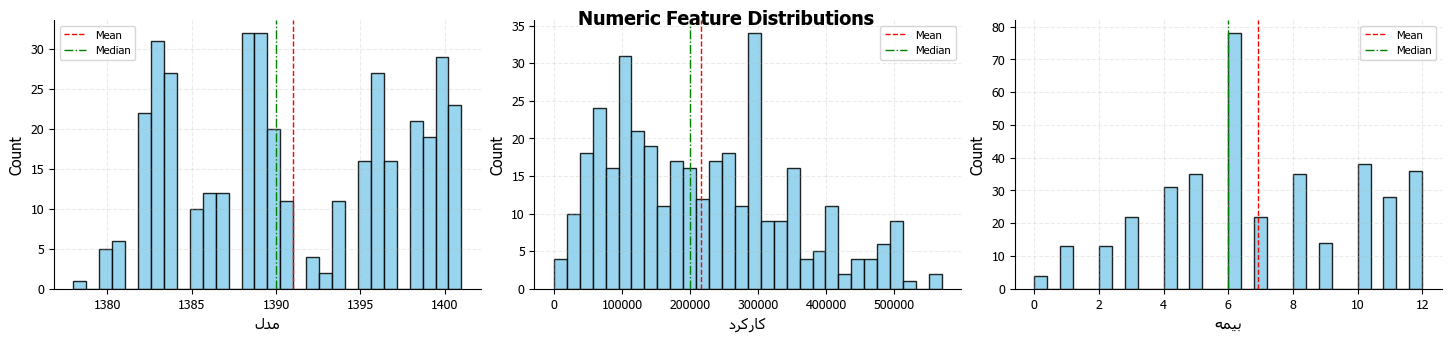

In [30]:
ncols = 3
nrows = int(np.ceil(len(numeric_cols) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(4.8*ncols, 3.2*nrows), constrained_layout=True)
axes = axes.ravel()

for i, c in enumerate(numeric_cols):
    ax = axes[i]
    data = df[c].astype(float).dropna()

    ax.hist(data, bins=30, color="skyblue", edgecolor="black", alpha=0.85)
    ax.axvline(data.mean(), color="red", linestyle="--", linewidth=1, label="Mean")
    ax.axvline(data.median(), color="green", linestyle="-.", linewidth=1, label="Median")

    ax.set_xlabel(get_display(arabic_reshaper.reshape(str(c))), fontname="Tahoma")
    ax.set_ylabel("Count", fontname="Tahoma")
    ax.legend(fontsize=8)

fig.suptitle("Numeric Feature Distributions", fontsize=14, fontweight="bold", y=1.02)
plt.show()

For categorical columns: fill missing with mode (most frequent)

In [31]:
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

For numeric columns: fill missing with median

In [32]:
for col in numeric_cols:
    df[col] = df[col].apply(persian_to_english)
    df[col] = df[col].str.replace(r"[^\d.]", "", regex=True)
    df[col] = pd.to_numeric(df[col], errors="coerce")
    df[col] = df[col].fillna(df[col].median())

In [33]:
print("\nMissing values:\n", df.isnull().sum())


Missing values:
 نوع رنگ    0
مدل        0
کارکرد     0
بیمه       0
موتور      0
شاسی       0
بدنه       0
عکس        0
قیمت       0
شهر        0
dtype: int64


In [34]:
df.describe(include="all")

,نوع رنگ,مدل,کارکرد,بیمه,موتور,شاسی,بدنه,عکس,قیمت,شهر
count,390,390.000000,390.000000,390.000000,390,390,390,390,3.900000e+02,390
unique,21,NaN,NaN,NaN,3,3,10,2,NaN,24
top,سفید,NaN,NaN,NaN,سالم,سالم و پلمپ,سالم و بی خط و خش,دارد,NaN,تبریز
freq,192,NaN,NaN,NaN,368,359,199,383,NaN,55
mean,NaN,1391.035897,214673.920513,6.866667,NaN,NaN,NaN,NaN,3.880133e+08,NaN
std,NaN,6.465947,125113.150715,3.056060,NaN,NaN,NaN,NaN,1.420505e+08,NaN
min,NaN,1378.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,3.400000e+06,NaN
25%,NaN,1385.000000,109250.000000,5.000000,NaN,NaN,NaN,NaN,2.700000e+08,NaN
50%,NaN,1390.000000,200000.000000,6.000000,NaN,NaN,NaN,NaN,3.700000e+08,NaN
75%,NaN,1397.000000,300000.000000,10.000000,NaN,NaN,NaN,NaN,4.945000e+08,NaN


Features and target

In [35]:
X = df[feature_cols]
y = df[TARGET]

Split: Train (80%) and Test (20%)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

In [37]:
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (312, 9), Test: (78, 9)


In [38]:
num_all = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_all = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_all = ColumnTransformer(
    transformers=[
        ("num", num_all, numeric_cols),
        ("cat", cat_all, categorical_cols),
    ],
    remainder="drop"
)
preprocess_all

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['مدل', 'کارکرد', 'بیمه']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['نوع رنگ', 'موتور', 'شاسی', 'بدنه', 'عکس',
                                  'شهر'])])

In [39]:
def build_pipeline(model):
    return Pipeline([("prep", preprocess_all), ("model", model)])

In [40]:
pipe_knn = build_pipeline(KNeighborsRegressor())

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
param_grid = {
    "model__n_neighbors": range(1, 31),
    "model__weights": ["uniform", "distance"],
    "model__p": [1, 2],
}

grid = GridSearchCV(
    estimator=pipe_knn,
    param_grid=param_grid,
    cv=cv,
    scoring="r2",
    n_jobs=-1,
    refit=True
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV R²:", round(grid.best_score_, 4))

Best params: {'model__n_neighbors': 17, 'model__p': 2, 'model__weights': 'distance'}
Best CV R²: 0.6242


In [41]:
test_pred = grid.best_estimator_.predict(X_test)
test_mae  = mean_absolute_error(y_test, test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
test_r2   = r2_score(y_test, test_pred)

print(f"TEST MAE : {test_mae:.2f}")
print(f"TEST RMSE: {test_rmse:.2f}")
print(f"TEST R²  : {test_r2:.4f}")

TEST MAE : 39718176.67
TEST RMSE: 54678856.63
TEST R²  : 0.8577


In [42]:
pipe_knn = build_pipeline(KNeighborsRegressor(
    n_neighbors=grid.best_params_['model__n_neighbors'],
    weights=grid.best_params_['model__weights'],
    p=grid.best_params_['model__p']
))
pipe_dt  = build_pipeline(DecisionTreeRegressor(random_state=RANDOM_STATE))
pipe_rf  = build_pipeline(RandomForestRegressor(random_state=RANDOM_STATE))
pipe_gbr = build_pipeline(GradientBoostingRegressor(random_state=RANDOM_STATE))

baseline_models = {
    "KNN":              pipe_knn,
    "DecisionTree":     pipe_dt,
    "RandomForest":     pipe_rf,
    "GradientBoosting": pipe_gbr,
}

In [43]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def cv_summary(name, est):
    scores = cross_validate(
        est, X_train, y_train,
        scoring={
            "r2": "r2",
            "neg_mae": "neg_mean_absolute_error",
            "neg_rmse": "neg_root_mean_squared_error",
        },
        cv=cv, n_jobs=-1, return_train_score=False
    )
    r2   = scores["test_r2"].mean()
    mae  = -scores["test_neg_mae"].mean()
    rmse = -scores["test_neg_rmse"].mean()
    print(f"{name:18s} | R²: {r2: .4f} | MAE: {mae: .2f} | RMSE: {rmse: .2f}")
    return {"r2": r2, "mae": mae, "rmse": rmse}

print("5-fold CV on TRAIN:")
baseline_results = {name: cv_summary(name, est) for name, est in baseline_models.items()}

5-fold CV on TRAIN:
KNN                | R²:  0.6242 | MAE:  55804418.89 | RMSE:  85929226.99
DecisionTree       | R²:  0.6115 | MAE:  53017762.42 | RMSE:  86185413.86
RandomForest       | R²:  0.6945 | MAE:  47464428.06 | RMSE:  77543747.56
GradientBoosting   | R²:  0.6553 | MAE:  50914395.41 | RMSE:  82102976.07


#### Define evaluation function

In [44]:
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae  = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)
    print(f"{name} Performance:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")
    print("-"*40)
    return {"model": model, "mae": mae, "rmse": rmse, "r2": r2}

In [45]:
test_results = {}

In [46]:
for name, est in baseline_models.items():
    print(f"=== {name} on Test ===")
    test_results[name] = evaluate_model(name, est, X_train, X_test, y_train, y_test)

=== KNN on Test ===
KNN Performance:
MAE: 39718176.67
RMSE: 54678856.63
R²: 0.86
----------------------------------------
=== DecisionTree on Test ===
DecisionTree Performance:
MAE: 42597435.90
RMSE: 68930247.17
R²: 0.77
----------------------------------------
=== RandomForest on Test ===
RandomForest Performance:
MAE: 35007192.31
RMSE: 49827507.13
R²: 0.88
----------------------------------------
=== GradientBoosting on Test ===
GradientBoosting Performance:
MAE: 37391268.58
RMSE: 52019649.05
R²: 0.87
----------------------------------------


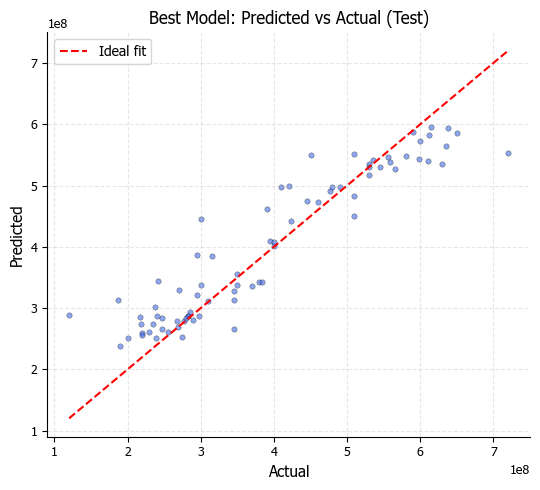

In [47]:
y_pred_best = grid.best_estimator_.predict(X_test)

plt.figure(figsize=(5.5, 5))
plt.scatter(y_test, y_pred_best, s=15, c="royalblue", alpha=0.6, edgecolors="k", linewidths=0.3)
mn, mx = np.min([y_test.min(), y_pred_best.min()]), np.max([y_test.max(), y_pred_best.max()])
plt.plot([mn, mx], [mn, mx], "r--", lw=1.5, label="Ideal fit")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Best Model: Predicted vs Actual (Test)")
plt.legend()
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

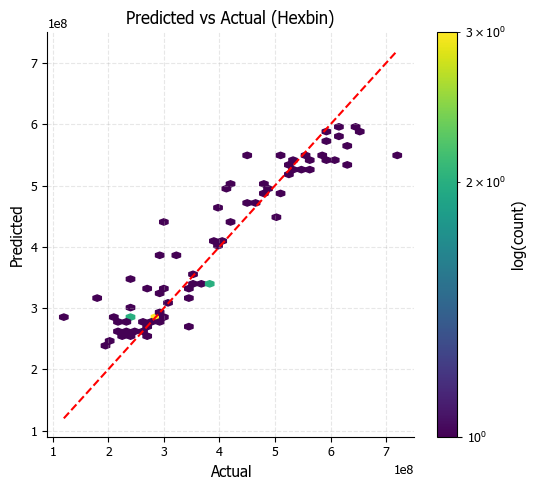

In [48]:
plt.figure(figsize=(5.5, 5))
hb = plt.hexbin(y_test, y_pred_best, gridsize=40, cmap="viridis", bins="log")
plt.plot([mn, mx], [mn, mx], "r--", lw=1.5)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual (Hexbin)")
cb = plt.colorbar(hb)
cb.set_label("log(count)")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

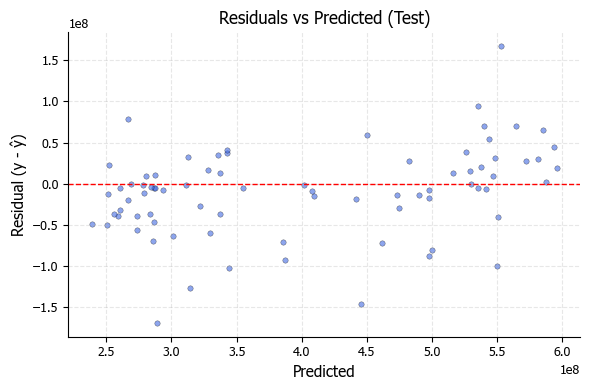

In [49]:
res = y_test - y_pred_best

plt.figure(figsize=(6, 4))
plt.scatter(y_pred_best, res, s=15, c="royalblue", alpha=0.6, edgecolors="k", linewidths=0.3)
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.xlabel("Predicted")
plt.ylabel("Residual (y - ŷ)")
plt.title("Residuals vs Predicted (Test)")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

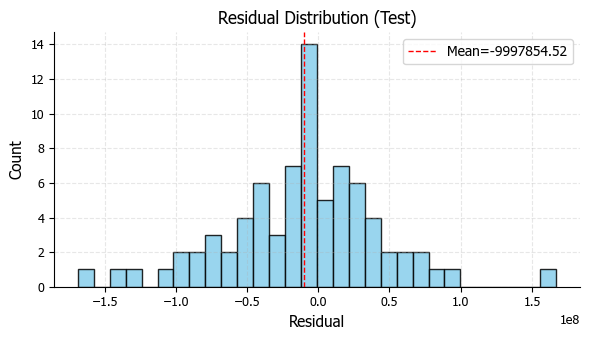

In [50]:
plt.figure(figsize=(6, 3.5))
plt.hist(res, bins=30, color="skyblue", edgecolor="black", alpha=0.85)
plt.axvline(res.mean(), color="red", linestyle="--", linewidth=1, label=f"Mean={res.mean():.2f}")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title("Residual Distribution (Test)")
plt.legend()
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

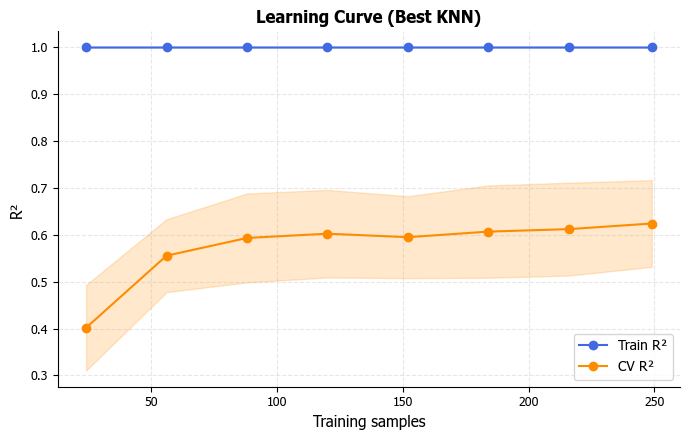

In [51]:
train_sizes, train_scores, val_scores = learning_curve(
    estimator=grid.best_estimator_,
    X=X_train, y=y_train,
    cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    train_sizes=np.linspace(0.1, 1.0, 8),
    scoring="r2",
    n_jobs=-1
)

plt.figure(figsize=(7, 4.5))

train_mean, train_std = train_scores.mean(axis=1), train_scores.std(axis=1)
val_mean, val_std   = val_scores.mean(axis=1), val_scores.std(axis=1)

plt.plot(train_sizes, train_mean, marker="o", color="royalblue", label="Train R²")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, 
                 color="royalblue", alpha=0.2)

plt.plot(train_sizes, val_mean, marker="o", color="darkorange", label="CV R²")
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, 
                 color="darkorange", alpha=0.2)

plt.xlabel("Training samples")
plt.ylabel("R²")
plt.title("Learning Curve (Best KNN)", fontsize=12, fontweight="bold")
plt.legend(frameon=True)
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

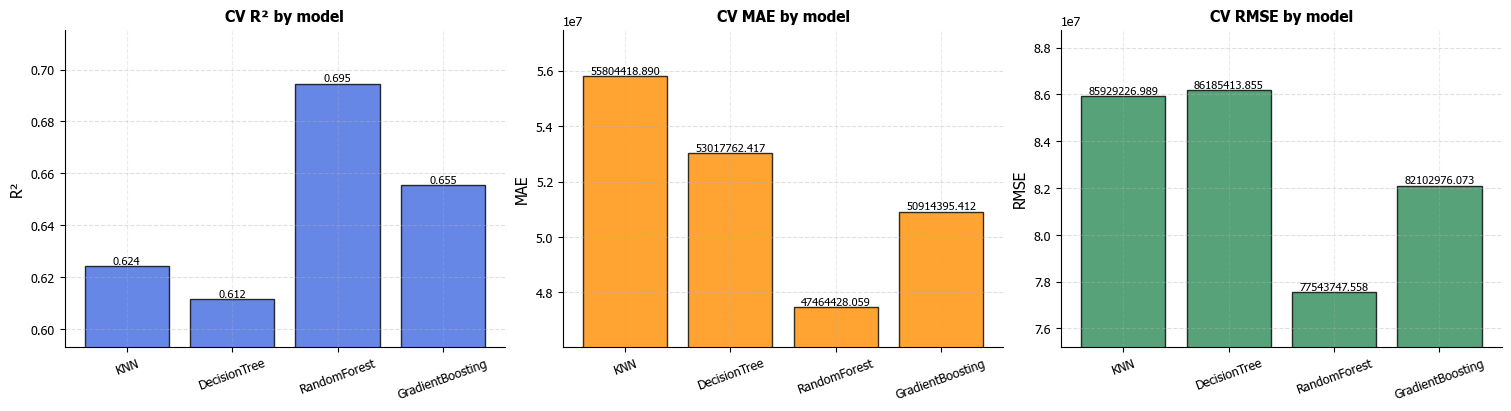

In [52]:
labels = list(baseline_results.keys())
r2_vals   = [baseline_results[k]["r2"] for k in labels]
mae_vals  = [baseline_results[k]["mae"] for k in labels]
rmse_vals = [baseline_results[k]["rmse"] for k in labels]

fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

metrics = [
    ("CV R² by model", r2_vals, "R²", "royalblue"),
    ("CV MAE by model", mae_vals, "MAE", "darkorange"),
    ("CV RMSE by model", rmse_vals, "RMSE", "seagreen")
]

for ax, (title, vals, ylabel, color) in zip(axes, metrics):
    idx = np.arange(len(labels))
    bars = ax.bar(idx, vals, color=color, alpha=0.8, edgecolor="black")

    # annotate values
    for bar, v in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f"{v:.3f}", ha="center", va="bottom", fontsize=8)

    ymin = min(vals) - (min(vals)*0.03)
    ymax = max(vals) + (max(vals)*0.03)
    ax.set_ylim(ymin, ymax)
    
    ax.set_title(title, fontsize=11, fontweight="bold")
    ax.set_ylabel(ylabel)
    ax.set_xticks(idx)
    ax.set_xticklabels(labels, rotation=20)
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    
plt.show()